In [1]:
#from spatial_metabolic_distribution import Maps, MetabolicPropertyMapsAssembler
from spectral_spatial_simulation import Model as SpectralSpatialModel
from spectral_spatial_simulation import FID
from sampling import Model as SamplingModel
from matplotlib.pyplot import legend, title
import matplotlib.pyplot as plt
from display import plot_FID
from easygraph import Graph
#from printer import Console
from prettyconsole import Console
import dask.array as da
import numpy as np
import cupy as cp
import os.path
import tools
import dask
import pint
import file
import h5py
import sys

from tqdm import tqdm
import warnings

# Both required for the JupyterPlotManager
from tools import JupyterPlotManager
%matplotlib ipympl

# For e.g., storing to disk (dask.to_zarr)
from tools import DaskTools

# For some incomplete data
from spatial_metabolic_distribution import ParameterMap, ParameterVolume

NameError: name 'direction' is not defined

In [ ]:
# Initialise the UnitRegistry
u = pint.UnitRegistry()

# Check number of reserved CPUs and total available CPUs

In [ ]:
print("available number of CPUs for this simulation (vary if reserved):")
!nproc

In [ ]:
print("all logical CPUs on the system:")
!nproc --all

# Check current GPU load & Define GPU(s) for small and big tasks

In [ ]:
# Set generally visible GPU devices

!nvidia-smi

In [ ]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

#target_gpu_smaller_tasks = 2
#target_gpus_big_tasks = [3]

target_gpu_smaller_tasks = 2
target_gpus_big_tasks = [1,2,3]

device_memory_limit = "32GB"

# Check free RAM

In [ ]:
!free -h

# <span style="color:red">Define Simulation paramaters (TODO collect all important ones). Are they already base units?!</span>

In [ ]:
TE=0.0013*u.s  # secound
TR=0.6*u.s     # secound
alpha=45*u.deg # degree

# Load defined paths in the configurator

In [ ]:
config_file_name = "paths_09012026.json"

In [ ]:
configurator = file.Configurator(path_folder="../config/",
                                 file_name=config_file_name)
configurator.load()

# Load metabolic mask

In [ ]:
metabolic_mask = file.Mask(configurator=configurator)
metabolic_mask.load(mask_name="metabolites", data_type=np.float32)

In [ ]:
metabolic_mask.plot_jupyter()

# Load the FIDs

In [ ]:
metabolites = file.FID(configurator=configurator)
metabolites.load(fid_name="metabolites", signal_data_type=np.complex64) # TODO TODO, here seems to be an issue => data type has no effect?
metabolites.loaded_fid.change_signal_data_type("complex64")
metabolites.loaded_fid.change_time_data_type("float32")

In [ ]:
loaded_fid = metabolites.loaded_fid
loaded_fid.plot()

#### <span style="color:red">!!! Interpolate to 100.000 FID points for test purposes.</span>

In [ ]:
loaded_fid.interpolate(timepoints=100_000)

# Load and prepare the concentration maps

#### Load the desired concentration maps

In [ ]:
loaded_concentration_maps = file.ParameterMaps(configurator=configurator, map_type_name="metabolites_concentration")
working_name_and_file_name = {"Glu": "MetMap_Glu_con_map_TargetRes_HiRes.nii",
                              "Gln": "MetMap_Gln_con_map_TargetRes_HiRes.nii",
                              "m-Ins": "MetMap_Ins_con_map_TargetRes_HiRes.nii",
                              "NAA": "MetMap_NAA_con_map_TargetRes_HiRes.nii",
                              "Cr+PCr": "MetMap_Cr+PCr_con_map_TargetRes_HiRes.nii",
                              "GPC+PCh": "MetMap_GPC+PCh_con_map_TargetRes_HiRes.nii",
                             }
loaded_concentration_maps.load_files_from_folder(working_name_and_file_name=working_name_and_file_name)

#### Convert to base units and display loaded data

In [ ]:
# Convert to base units (e.g., mmol to mol)
loaded_concentration_maps.to_base_units()
# Display the data
import time
time.sleep(1)
loaded_concentration_maps.plot_jupyter(cmap="viridis")

#### Create 4D array from the 3D arrays and interpolate to target shape

In [ ]:
# Convert the file.Maps object to a ParamaterVolume of shape (metabolite, X, Y, Z) & change to float32
concentration_volume = loaded_concentration_maps.to_working_volume(data_type="float32")

# Interpolate to the shape of the 
concentration_volume.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)

# Load and prepare the T1 maps
### <span style="color:red">!!! Only one T1 map is loaded at the moment and used for each metabolite.</span>

#### <span style="color:red">!!! Load only one t1 maps and then convert to base units.</span>

In [ ]:
loaded_t1_map = file.ParameterMaps(configurator=configurator, map_type_name="T1")
loaded_t1_map.load_file()
loaded_t1_map.to_base_units()

#### <span style="color:red">!!! Assemble pseudo 4D array of T1 maps (same for each metabolite).</span>

In [ ]:
t1_volume = ParameterVolume(maps_type="T1")

for metabolite in concentration_volume.metabolites:
    parameter_map = ParameterMap(map_type=loaded_t1_map.map_type_name, metabolite_name=metabolite, values=loaded_t1_map.loaded_maps, unit=loaded_t1_map.loaded_maps_unit)
    t1_volume.add_map(parameter_map)

t1_volume.to_volume()
t1_volume.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)
t1_volume.to_data_type("float32")

In [ ]:
np.min(t1_volume.volume)

#### <span style="color:red">!!! TODO TODO TODO TODO: Maybe implement this function?.</span>

In [ ]:
##print(np.min(t1_volume.volume))
##print((t1_volume.volume == 0).sum())
###t1_volume.volume = tools.ArrayTools.negative_to_eps(t1_volume.volume)
##
##import numpy as np
##
##def count_zero_and_near_zero(t1, eps=1e-6):
##    """
##    Count exact zeros and near-zeros in a NumPy array.
##    """
##    t1 = np.asarray(t1)
##
##    n_total = t1.size
##    n_zero = np.count_nonzero(t1 == 0)
##    n_near = np.count_nonzero((np.abs(t1) < eps) & (t1 != 0))
##
##    return {
##        "total": int(n_total),
##        "zero_count": int(n_zero),
##        "zero_percent": 100.0 * n_zero / n_total if n_total else 0.0,
##        "near_zero_count": int(n_near),
##        "near_zero_percent": 100.0 * n_near / n_total if n_total else 0.0,
##        "eps": float(eps),
##        "min_abs": float(np.min(np.abs(t1))) if n_total else float("nan"),
##    }
##
##stats = count_zero_and_near_zero(t1_volume.volume, eps=1e-6)
##print(stats)

#from tools import ArrayTools
#t1_volume.volume = ArrayTools.negative_to_eps(array=t1_volume.volume)

#np.min(t1_volume.volume)

In [ ]:
from tools import ArrayTools
ArrayTools.check_nan(t1_volume.volume)
ArrayTools.count_zeros(t1_volume.volume)

In [ ]:
t1_volume.display_jupyter(display="volume")

# Load and prepare the T2 maps

#### <span style="color:red">!!! The reference where T2 vales ares used from. Only homogenious at the moment.</span>

In [ ]:
# Using T2 values from:
cm = tools.CitationManager("../docs/references.bib")
cm.cite("versteeg2024high")
# But also see:
cm.cite("seginer2022phase")

t2_WM = (25+39)/2*u.ms
t2_GM = (33+55)/2*u.ms

t2_GM_WM_average = (t2_WM+t2_GM)/2
t2_GM_WM_average = t2_GM_WM_average.to_base_units()

t2_GM_WM_average
# Do I have GM and WM segmentation?

In [ ]:
t2_volume = ParameterVolume(maps_type="T2")

for metabolite in concentration_volume.metabolites:
    parameter_map = ParameterMap(map_type="T2", metabolite_name=metabolite, values=np.full(metabolic_mask.mask.shape, t2_GM_WM_average), unit=t2_GM_WM_average.units)
    t2_volume.add_map(parameter_map)

t2_volume.to_volume()
t2_volume.to_data_type("float32")
#t2_volume.interpolate_volume(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)

In [ ]:
import time
time.sleep(2)
t2_volume.display_jupyter()

# Use desired FID signals and merge some of them

In [ ]:
using_fid_signals = ["Glutamate (Glu)",
                     "Glutamine_noNH2 (Gln)",
                     "MyoInositol (m-Ins)",
                     "NAcetylAspartate (NAA)",
                     "Creatine (Cr)",
                     "Phosphocreatine (PCr)",
                     "Choline_moi(GPC)",
                     "Glycerol_moi(GPC)",
                     "PhosphorylCholine_new1 (PC)"]

In [ ]:
# Take a subset of all signals of the FID. This returns a new FID object.
fid = loaded_fid.get_partly_fid(using_fid_signals)

# Merge signals of the FID in order to match the Maps
fid.merge_signals(names=["Creatine (Cr)", "Phosphocreatine (PCr)"],
                  new_name="Cr+PCr",
                  divisor=2)

fid.merge_signals(names=["Choline_moi(GPC)", "Glycerol_moi(GPC)", "PhosphorylCholine_new1 (PC)"],
                  new_name="GPC+PCh",
                  divisor=2)

fid.name = fid.get_name_abbreviation()

# Create Spectral-Spatial Model (Spectral-spatial combination)

Incorporating the T1 and T2 effects: T1 transform the signal height (Recovery). Thus bigger T1 or shorter TR -> less signal. T2 dampens the signal, this bigger T2 -> slower decay. Bigger T2 -> faste decay (less signal)

T1-transform:
$V_{\text{out}} = V_{\text{in}} \, \sin(\alpha)\, \frac{1 - e^{-TR/T_1}}{1 - \cos(\alpha)\, e^{-TR/T_1}}$

T2-transform:
$V_{\text{out}} = V_{\text{in}} \, e^{-\frac{TE + t}{T_2}}$


#### Ensure that each map has the same order

In [ ]:
# (1) Ensure that the metabolite order is the same for all volumes
desired_order = ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']
concentration_volume.reorder_metabolites(desired_order)
t1_volume.reorder_metabolites(desired_order)
t2_volume.reorder_metabolites(desired_order)

#### Create the model

In [ ]:
block_size = (int(60), int(112), int(128), int(80))

spectral_spatial_model = SpectralSpatialModel(path_cache=configurator.data["cache"],
                                              block_size=block_size,  # Note, also possible: 1536x10x10x10
                                              TE=TE,
                                              TR=TR,
                                              alpha=alpha,
                                              data_type="complex64",
                                              compute_on_device="gpu",
                                              return_on_device="gpu") # TODO: When doing here cpu next part then cuda has issue!


# Add all the parameter maps (spatial)
spectral_spatial_model.add_parameter_volume("T1", t1_volume)
spectral_spatial_model.add_parameter_volume("T2", t2_volume)
spectral_spatial_model.add_parameter_volume("concentration", concentration_volume)
spectral_spatial_model.add_mask(metabolic_mask.mask.data)                       # Mask of brain

# Add the FID signals (spectral)
#fid.time = fid.time * u.s # to add seconds # TODO
spectral_spatial_model.add_fid(fid)                                             # Add FID (all separate signals summed up)

spectral_spatial_model.model_summary()

In [ ]:
# To just check the data types
print("fid signal:", spectral_spatial_model.fid.signal.dtype)
print("fid time:", spectral_spatial_model.fid.time.dtype)
print("mask:", spectral_spatial_model.mask.dtype)
print("T1:", spectral_spatial_model.parameter_volumes["T1"].volume.dtype)
print("T2:", spectral_spatial_model.parameter_volumes["T2"].volume.dtype)
print("concentration:", spectral_spatial_model.parameter_volumes["concentration"].volume.dtype)

In [ ]:
computational_graph_0 = spectral_spatial_model.assemble_graph()
computational_graph_0

In [ ]:
computational_graph_0[0:1000,:,:,:]

In [ ]:
### # 1) Start Cluster
### cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
### #cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
### #WORKS on DL: 
### cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")
### 
### #------------------------------------------------
### Console.start_timer()
### 
### #test_gpu = test_graph[0,0:1000,:,:,:].compute()
### spectral_spatial_volume = computational_graph_0[0:1000,:,:,:].compute()
### 
### 
### Console.stop_timer()
### #------------------------------------------------
### 
### # 3) Close client and cluster
### cluster.close()

In [ ]:
### from tools import ArrayTools
### ArrayTools.check_nan(spectral_spatial_volume.get())

In [ ]:
# TODO Check the model pint quantities:
print(type(spectral_spatial_model.fid.time))
print(type(spectral_spatial_model.fid.signal))
print(type(spectral_spatial_model.mask))
print(type(spectral_spatial_model.alpha))
print(type(spectral_spatial_model.TE))
print(type(spectral_spatial_model.TR))

In [ ]:
metabolic_mask.mask.data.shape

In [ ]:
computational_graph_0[0:100, :, :, :]

In [ ]:
### ### TODO: Check the data of the spectral spatial model! ARE HERE NANS?
### 
### # 1) Start Cluster
### cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
### #cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
### #WORKS on DL: 
### cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")
### 
### #------------------------------------------------
### Console.start_timer()
### 
### #test_gpu = test_graph[0,0:1000,:,:,:].compute()
### test_spectral_spatial_model =computational_graph_0[0:100, :, :, :].compute()
### 
### 
### Console.stop_timer()
### #------------------------------------------------
### 
### # 3) Close client and cluster
### cluster.close()

In [ ]:
### print(test_spectral_spatial_model.shape)
### print(test_spectral_spatial_model[:,60,60,20])
### 
### import matplotlib.pyplot as plt
### plt.figure()
### plt.imshow(np.abs(test_spectral_spatial_model[50,:,:,40]))
### plt.show()

In [ ]:

#UU = da.fft.fftn(test_spectral_spatial_model, (-1,-2,-3))

# Sampling model

### Load the coil sensitivity maps

In [ ]:
coil_sensitivity_maps_loader = file.CoilSensitivityMaps(configurator=configurator)
coil_sensitivity_maps_loader.load_h5py(keys=["imag", "real"], dtype=np.complex64)

In [ ]:
#coil_sensitivity_maps_loader.plot_jupyter(cmap="viridis")
coil_sensitivity_maps_loader.plot(cmap="viridis")

### Convert to working volume and interpolate

In [ ]:
coil_sensitivity_volume = coil_sensitivity_maps_loader.to_working_volume()
coil_sensitivity_volume.interpolate(target_size=metabolic_mask.mask.shape, target_gpu=target_gpu_smaller_tasks)

### Create the sampling model & Apply the coil sensitivity maps

In [ ]:
#block_size = (32, 35, 112, 128, 80)
### block_size = (4, 35, 112, 128, 80) # seem to work very good!
block_size = (4, 60, 112, 128, 80) # stest with bigger chunksize

#### TODO coil chunksize sollte nicht 32 sein!!!

sampling_model = SamplingModel(block_size=block_size, 
                               path_cache=configurator.data["cache"], 
                               data_type="complex64", 
                               coil_sensitivity_volume=coil_sensitivity_volume,
                               spectral_spatial_volume=computational_graph_0)

# TODO: Implement to print summary!!!! sampling_model.summary()

In [ ]:
# Apply coil sensitivity maps
out_sampling_0 = sampling_model.apply_coil_sensitivity(compute_on_device="gpu", return_on_device="gpu")

In [ ]:
out_sampling_0

## FFT + FFT shift + crop center

In [ ]:
# Here try tp use dask fft.fftn and check if it runs on gpu or cpu!

In [ ]:
#out_sampling_0_rechunked = out_sampling_0.rechunk(("auto", "auto", -1,-1,-1))#.rechunk({0: 1, 1: 1, 2: -1, 3: -1, 4: -1})
out_sampling_0_rechunked = out_sampling_0.rechunk((block_size[0], block_size[1], -1,-1,-1))
#out_sampling_0X = out_sampling_0X.astype("complex128")
print(out_sampling_0_rechunked.shape)
print(out_sampling_0_rechunked.shape[2:])
out_sampling_0_rechunked

In [ ]:
#out_sampling_0_rechunked_fft = da.fft.fftn(out_sampling_0_rechunked, axes=(2, 3, 4)) # out_sampling_0X.shape[2:]
out_sampling_0_rechunked_fft = out_sampling_0_rechunked.map_blocks(cp.fft.fftn, axes=(2, 3, 4), dtype=cp.complex64)
out_sampling_0_rechunked_fft[16,0:100, :,:,:]

In [ ]:
#out_sampling_0_rechunked_fft_shifted = da.fft.fftshift(out_sampling_0_rechunked_fft, axes=(2, 3, 4))
out_sampling_0_rechunked_fft_shifted = out_sampling_0_rechunked_fft.map_blocks(cp.fft.fftshift, axes=(2, 3, 4), dtype=cp.complex64)
out_sampling_0_rechunked_fft_shifted

In [ ]:
## nun crop center und dann ifft => ganzes voluem!

def center_crop(a: da.Array, crop_center_shape=(64, 64, 40)) -> da.Array:
    # a.shape: (B, T, X, Y, Z)
    cx, cy, cz = crop_center_shape
    X, Y, Z = a.shape[-3:]  # may be ints or numpy ints; should be known for slicing

    if any(s is None for s in (X, Y, Z)):
        raise ValueError(
            "Center crop needs known sizes for X,Y,Z. "
            "If they're unknown, rechunk/load in a way that materializes the shape."
        )

    if cx > X or cy > Y or cz > Z:
        raise ValueError(f"Crop {crop_center_shape} larger than spatial shape {(X, Y, Z)}")

    sx = (X - cx) // 2
    sy = (Y - cy) // 2
    sz = (Z - cz) // 2

    return a[..., sx:sx+cx, sy:sy+cy, sz:sz+cz]

In [ ]:
# cropped volume
k_space_crop_shape = (64, 64, 40)
out_sampling_1_fft_center = center_crop(out_sampling_0_rechunked_fft_shifted, k_space_crop_shape)
out_sampling_1_fft_center

# TODO: Add gaussian NOISE. Certain SNR

In [ ]:
# TODO: Compute based on seed voxel?

## IFFT

In [ ]:
#out_sampling_0_rechunked_back = da.fft.ifftn(out_sampling_1_fft_center, axes=(2, 3, 4))
out_sampling_0_rechunked_back = out_sampling_1_fft_center.map_blocks(cp.fft.ifftn, axes=(2, 3, 4), dtype=cp.complex64)

In [ ]:
out_sampling_0_rechunked_back[0, 0:1000,:,:,:]

In [ ]:
### # 1) Start Cluster
### cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
### #cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
### #WORKS on DL: 
### cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")
### 
### #------------------------------------------------
### Console.start_timer()
### 
### #test_gpu = test_graph[0,0:1000,:,:,:].compute()
### test_gpu = out_sampling_0_rechunked_back[0, 0:1000,:,:,:].compute()
### 
### 
### Console.stop_timer()
### #------------------------------------------------
### 
### # 3) Close client and cluster
### cluster.close()

In [ ]:
# case 1:
#  dask fftn, ifftn
#  GPU Allocation: GPU1:28,GPU2:28,GPU3:32
#  time: 67 sec

# case 2:
#  map blocks cupy: fftn, ifftn
#  GPU Allocation: GPU1:28,GPU2:28,GPU:3:26
#  time: 98 sec 

In [ ]:
#test_gpu.dtype

## COIL Combination

In [ ]:
####### ALREADY START HERE CLUSTER, to have data on rigth gpu with persists:
###
#### 1) Start Cluster
###cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
####cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
####WORKS on DL: 
###cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

In [ ]:
#from tools import GPUTools

out_sampling_0_rechunked_back.chunksize

In [ ]:
#da.sum()

# wann dann coil combination?
from tools import GPUTools
import copy

# 1) Create dask array from coils sensitivity volume <- maybe before make conjugated complex <- also before interpolate to target size
#   1a) Interpolate to target size
coil_sensitivity_volume2 = copy.deepcopy(coil_sensitivity_volume)
coil_sensitivity_volume2.interpolate_volume(target_size=k_space_crop_shape, target_gpu=target_gpu_smaller_tasks)
#   2a) Conjugated complex
coil_sensitivity_volume2_conj = copy.deepcopy(coil_sensitivity_volume2)
coil_sensitivity_volume2_conj.conjugate()

#   2b) Compute denominator


#   3a) Create dask array
coil_sensitivity_volume2_dask = da.asarray(coil_sensitivity_volume2.volume, chunks=(out_sampling_0_rechunked_back.chunksize[0], -1,-1,-1))
coil_sensitivity_volume2_conj_dask = da.asarray(coil_sensitivity_volume2_conj.volume, chunks=(out_sampling_0_rechunked_back.chunksize[0], -1,-1,-1))
#   4a) Bring to GPU via dask map blocks
coil_sensitivity_volume2_dask_gpu = GPUTools.dask_map_blocks(coil_sensitivity_volume2_dask, device="gpu")
coil_sensitivity_volume2_conj_dask_gpu = GPUTools.dask_map_blocks(coil_sensitivity_volume2_conj_dask, device="gpu")
coil_sensitivity_volume2_conj_dask_gpu = coil_sensitivity_volume2_conj_dask_gpu[:,None, ...]

#### TODO: PUSH TO GPU, but already should be there!
###out_sampling_0_rechunked_back_gpu = GPUTools.dask_map_blocks(out_sampling_0_rechunked_back, device="gpu")

# 2) Then this (MRSI volume * coil_sensitivity_complex_conj) / |sum(coil_sensitivity, axis=0)|^2
numerator = da.sum(out_sampling_0_rechunked_back * coil_sensitivity_volume2_conj_dask_gpu, axis=0) # maybe first cpu and then dask gpu
denominator = (cp.sum(cp.abs(GPUTools.to_device(coil_sensitivity_volume2.volume, device="gpu"))**2, axis=0)) #da.sum(da.abs(coil_sensitivity_volume2_dask_gpu)**2, axis=0)
denominator = da.from_array(denominator, chunks=(-1,-1,-1))

out = numerator / denominator
#out = da.sum(out_sampling_0_rechunked_back * coil_sensitivity_volume2_conj_dask_gpu[:,None, ...], axis=0) / da.sum(da.abs(coil_sensitivity_volume2_dask_gpu)**2, axis=0)
#out = da.sum(out_sampling_0_rechunked_back * coil_sensitivity_volume2_conj_dask_gpu[:,None, ...], axis=0) / da.sum(coil_sensitivity_volume2_dask_gpu * coil_sensitivity_volume2_conj_dask_gpu, axis=0)

# 3)
out

In [ ]:
da.sum(da.abs(coil_sensitivity_volume2_dask_gpu)**2, axis=0)

In [ ]:
out

In [ ]:
print(out_sampling_0_rechunked_back.shape, out_sampling_0_rechunked_back.chunksize)
print(coil_sensitivity_volume2_conj_dask_gpu.shape, coil_sensitivity_volume2_conj_dask_gpu.chunksize)


In [ ]:
out[0:1000,:,:,:]

In [ ]:
out

In [ ]:
!free -h

In [70]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

#test_gpu = test_graph[0,0:1000,:,:,:].compute()
#test_gpu = out.compute()
test_gpu = out

from tools import DaskTools, GPUTools

test_cpu = GPUTools.dask_map_blocks(test_gpu, device="cpu")
test_cpu = DaskTools.to_zarr(test_cpu, path=configurator.data["checkpoints"], checkpoint_folder_name="checkpoint_out_test_30012026")
test_cpu = test_cpu.compute()

Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

[ 55  ][ warning ] >> nvml diagnostics is disabled!                                                                        
[ 56  ][  info   ] >> Splitting large chunks is activated                                                                  
[ 57  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        
         START TIMER          


/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 13.24 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


       TOOK 734.314 sec       
[ 58  ][ success ] >> Successfully closed client                                                                           
[ 59  ][ success ] >> Successfully closed cluster                                                                          


In [71]:
#test_cpu = test_gpu.get()

In [72]:
##import matplotlib.pyplot as plt
##
##plt.figure()
##plt.imshow(np.abs(test_cpu[500, :, :, 20]))
##plt.show()

In [73]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           251Gi        17Gi        81Gi       6.9Gi       152Gi       224Gi
Swap:             0B          0B          0B


In [74]:
import os
import dask.array as da

In [75]:
XX = da.from_zarr(os.path.join(configurator.data["checkpoints"], "checkpoint_out_test_30012026"))

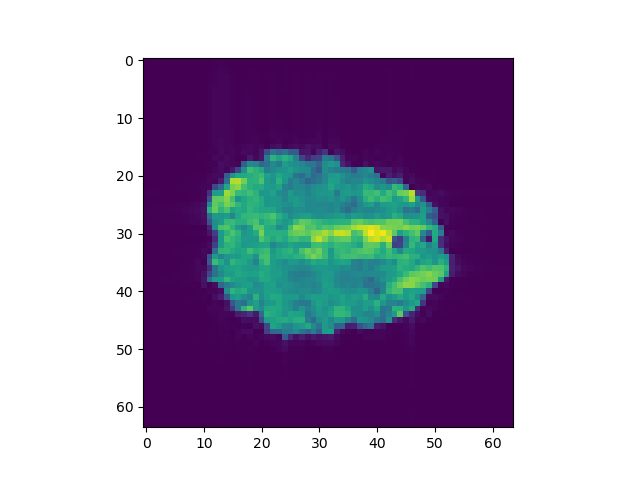

In [76]:
plt.figure()
plt.imshow(np.abs(XX[500, :, :, 20]))
plt.show()

In [ ]:
# Apply fft and cropping
crop_center_shape = (64, 64, 40)
out_sampling_1 = sampling_model.apply_cartesian_FFT(compute_on_device="gpu", return_on_device="cpu", crop_center_k_space_xyz=crop_center_shape, rechunking=True)

In [ ]:
out_sampling_1[0,0:1000,:,:,:]

In [ ]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

#test_gpu = test_graph[0,0:1000,:,:,:].compute()
test_gpu = out_sampling_1[0,0:1000,:,:,:].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

In [ ]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

#test_gpu = test_graph[0,0:1000,:,:,:].compute()
test_gpu = out_sampling_1[0,0:1000,:,:,:].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

In [ ]:
np.abs(test_gpu[100,:,:, 20])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.imshow(np.abs(test_gpu[100,:,:, 20]))
plt.savefig("slice_100_20.png", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.abs(test_gpu[0,:,:,40]))
plt.show()

In [ ]:
### TODO: Next step is coil combination!?

# Cartesian k-Space & Cropping

In [ ]:
crop_center_shape = (64, 64, 40)

g.add_node(name="Cartesian Fourier Transformation",
           text=f"To bring the 4D volume of each coil to k-space and to spatially crop the center for each to {crop_center_shape}.", 
           cluster="k-space")

computational_graph_3 = sampling_model.cartesian_FFT(volumes_with_coil_sensitivity_maps=computational_graph_2,
                                                     crop_center_shape=crop_center_shape,
                                                     compute_on_device='cuda',  # cuda works with 100_000
                                                     return_on_device='cuda')   # cpu works with 100_000

#### <span style="color:red">!!! The following step is just a test regarding selecting the only the desired GPU (not utilise GPU = as currently)</span>

In [ ]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

test_gpu = computational_graph_3[0].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

# Back to i-Space (IFFT)

In [ ]:
g.add_node(name="Cartesian Fourier Transformation",
           text=f"To bring the 4D volume of each coil to k-space and to spatially crop the center for each to {crop_center_shape}.", 
           cluster="k-space")

computational_graph_4 = sampling_model.cartesian_IFFT(volumes_cartesian_k_space=computational_graph_3,
                                                      compute_on_device='cuda',   # cuda work with 100_000
                                                      return_on_device='cuda')    # cpu work with 100_000

In [ ]:
interpolate_sensitivity_maps = (32,) + crop_center_shape

g.add_node(name="Interpolate coil sensitivity (ifft)", text=f"Interpolate coil sensitivity maps to {interpolate_sensitivity_maps}. For Coil combination after IFFT.", cluster="Interpolation", width=0.5)

coil_sensitivity_maps_resized = coil_sensitivity_maps_loader.interpolate(target_size=interpolate_sensitivity_maps, order=2, compute_on_device='cuda', gpu_index=target_gpu_smaller_tasks, return_on_device='cuda') # TODO TODO TODO TODO

In [ ]:
computational_graph_4

In [ ]:
import cupy as cp
import dask
import dask.array as da


graphs_da = da.stack([da.asarray(g) for g in computational_graph_4], axis=0)   # (32,1536,64,64,40)
coils_da  = da.stack([da.asarray(c) for c in coil_sensitivity_maps_resized], axis=0)  # (32,64,64,40)

# IMPORTANT: make coils broadcast over the 1536 dimension
coils_da_b = coils_da[:, None, ...]  # (32,1,64,64,40)

num_da = da.sum(graphs_da * da.conj(coils_da_b), axis=0)   # -> (1536,64,64,40)
den_da = da.sum(da.absolute(coils_da) ** 2, axis=0)        # -> (64,64,40)

In [ ]:
text = f""" =====================================================================================================
        Step: Compute the forward process
        
        Description: `This computes the sampling model and also includes a forward process to check the data.`
            [x] 1. Bring to k-space (thus FFT to dimensions 1,2,3 excluding 0)
            [x] 2. Crop the center to {crop_center_shape}
            [x] 3. IFFT back to image space
            [x] 4. Interpolate coil sensitivity maps to {crop_center_shape}
            [x] 5. Could combination with resized coil sensitivity maps
        
        """

g.add_node(name="Compute the forward process",
           text=text,
           cluster="GPU cluster",
           title_colour="green")


# Start cluster again!
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

num, den = dask.compute(num_da, den_da) 

num = cp.asnumpy(num) if isinstance(num, cp.ndarray) else num
den = cp.asnumpy(den) if isinstance(den, cp.ndarray) else den

Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()
# 4) Convert again to dask array
computational_graph_1 = da.from_array(volume_computed, chunks=block_size)

#### <span style="color:red">Signal height is too much?</span>

In [ ]:
result = num/den
result.shape

test_fid = FID()

for i in range(5,35,5):
    test_fid += FID(
        signal=result[:,i,i,i], 
        time=loaded_fid.time, 
        name=[f"test FID [:,{i},{i},{i}]"])

#test_fid = FID(signal=result[:,20,20,20], time=loaded_fid.time, name=["test FID 1"])
test_fid.plot(additional_description="The Signal of the FID \n of the respective spactial position \n after cartesian FFT, cropping, IFFT and \n coil combination. \n Volume shape: [1536x64x64x40]", plot_offset=10000)

In [ ]:
#result

In [ ]:
#plt.plot(result[:, 20,20,20].compute())

#result.shape

In [ ]:
g.create()
g.save("cartesian__easy_graph_test_2")

In [ ]:
import dask, distributed, bokeh
import dask_labextension

print("dask:", dask.__version__)
print("distributed:", distributed.__version__)
print("bokeh:", bokeh.__version__)
print("dask_labextension:", dask_labextension.__version__)


In [ ]:
!jupyter lab --version